## EC-01 Genetic Algorithm
Affandy Fahrizain - J42322c

In [3]:
# ga_scheme.py
from deap import tools
import random

def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring


def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook



In [4]:
# draw_log.py
import matplotlib.pyplot as plt
import numpy as np

def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
# functions.py
import numpy as np
import math
import random

displace = random.random()

def rastrigin(individual):
    n = len(individual)
    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += (individual[i]-displace) * (individual[i]-displace)
        s2 += np.cos(c*(individual[i]-displace))
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [212]:
# ga_exp.py
from deap import tools, base
from multiprocessing import Pool
from numpy import random as rnd
import numpy as np
from deap import creator
from deap import benchmarks

creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

def mutation(individual, indpb=0.2):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.7)
            individual[i] = np.clip(individual[i], -5, 5)

    individual = tools.mutFlipBit(individual, indpb=indpb)
    # individual = tools.mutShuffleIndexes(individual, indpb=0.5)

    return individual

def cxSelf(ind1, ind2, indpb=0.5):
    cxTwo = tools.cxTwoPoint(ind1, ind2)
    cxUni = tools.cxUniform(cxTwo[0], cxTwo[1], indpb)
    return cxUni

In [229]:
class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.97
        self.cross_prob = 0.35

        self.function = function
        self.dimension = dimension

        # self.pool = Pool(5)
        self.engine = base.Toolbox()
        # self.engine.register("map", self.pool.map)
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        # self.engine.register("mate", tools.cxOnePoint)
        # self.engine.register("mate", tools.cxTwoPoint)        
        # self.engine.register("mate", tools.cxUniform, indpb=0.15)        
        self.engine.register("mate", cxSelf, indpb=0.15)
        # self.engine.register("mutate", tools.mutGaussian, mu=0, sigma=0.77, indpb=0.2)
        # self.engine.register("mutate", tools.mutFlipBit, indpb=0.2)
        self.engine.register("mutate", tools.mutShuffleIndexes, indpb=0.25)
        # self.engine.register("mutate", mutation, indpb=0.2)
        # self.engine.register("select", tools.selTournament, tournsize=4)
        self.engine.register("select", tools.selRoulette)
        self.engine.register("evaluate", self.function)


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, mutpb=self.mut_prob,
                                  ngen=self.iterations,
                                  stats=stats, halloffame=hof, verbose=True)
        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log


gen	nevals	avg    	std     	min    	max    
0  	100   	3.76025	0.197259	3.20034	4.15223
1  	80    	3.76127	0.189809	3.43172	4.15223
2  	80    	3.78946	0.201106	3.43172	4.15223
3  	80    	3.79185	0.183869	3.43325	4.1464 
4  	80    	3.77313	0.181737	3.43325	4.17126
5  	80    	3.76183	0.164416	3.43325	4.17126
6  	80    	3.79006	0.168219	3.46773	4.17126
7  	80    	3.79726	0.185144	3.46773	4.21387
8  	80    	3.84546	0.200429	3.4164 	4.21387
9  	80    	3.85179	0.21436 	3.4164 	4.21387
10 	80    	3.87052	0.204202	3.4164 	4.21387
11 	80    	3.88435	0.230563	3.46773	4.23876
12 	80    	3.88449	0.241811	3.39716	4.24682
13 	80    	3.91842	0.245637	3.39716	4.45017
14 	80    	3.9327 	0.248519	3.39716	4.41736
15 	80    	3.93735	0.256561	3.39716	4.45017
16 	80    	3.94988	0.2475  	3.4704 	4.45017
17 	80    	4.01358	0.235915	3.54723	4.45017
18 	80    	4.03904	0.24137 	3.55055	4.55933
19 	80    	4.03587	0.262201	3.55055	4.58088
20 	80    	4.05571	0.251376	3.55055	4.55933
21 	80    	4.13341	0.24997 	3.55

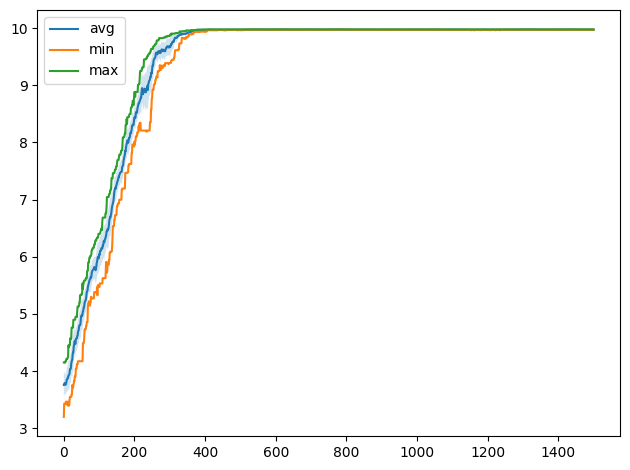

In [230]:
def function(x):
    res = rastrigin(x)
    return res,
    
dimension = 100 # set to 100
pop_size = 100 # max is 100
iterations = 1500 # max is 10000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)
log = scenario.run()

draw_log(log)

The algorithm with current parameters successfully found best fitness value 9.975. The fitness value started to stable around 500 iterations.

During the finding, we found that algorithm facing so called *Premature Converge* with default settings. Based on several literatures, it could be caused by setting of mutation and crossover rates. So we tried to increase mutation rate and otherwise for crossover rates, because we want to generate **better quality** parents before it being *inherited* to the children. Hence, we assume with better parents could be obtained better children too.

Unfortunately, just changing rates didn't solve the problem as we saw domination by some individuals. Based on another literature, it recommended to introduce fresh and random individuals in the population before starting crossover. Therefore, we tried to change our mutation strategy into *mutShuffleIndexes* as it promise to return mutant by shuffling individuals atribute.

Finally, we also changed our selection strategy into *Roulette* and noticed that it also reduce domination effect.

References:

1. [Premature Convergence](https://en.wikipedia.org/wiki/Premature_convergence#:~:text=Premature%20convergence%20is%20a%20common,which%20the%20alleles%20were%20present.)
2. [Fresh and Random Individuals before Crossover](https://stackoverflow.com/a/38286774)
3. [Why Premature Convergence Happens?](https://www.researchgate.net/post/Why-premature-convergence-happens)